# Semantic Segmentation - Drone Dataset



## 1. Dependencies

In [2]:
# Data visualization and management
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
# Images treatment
from PIL import Image
import cv2
import albumentations as A
# Other
import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Preprocessing

In [10]:
IMG_PATH = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/"
MASK_PATH = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/"

In [6]:
num_clases = 23 # the class #24 is 'unlabeled' 


def create_df(path: str) -> pd.DataFrame:
    '''
    This function creates a DataFrame using the filenames in a given directory.
    
    Args:
        path (str): The directory path from which to extract filenames.
        
    Returns:
        Any: The created DataFrame object.
    '''
    name = []  # List to store the filename without extension
    for directory, _, filenames in os.walk(path):
        [name.append(filename.split('.')[0]) for filename in filenames]
        
    # Creating a DataFrame with a single column "id" using the filenames
    # The index is set to a range of numbers from 0 to the length of the name list
    df = pd.DataFrame({"id": name}, index=np.arange(0, len(name)))
    
    return df


df = create_df(path=IMG_PATH)
print(f"Total number of images: ", len(df))

Total number of images:  400


In [8]:
# Train, validation, test split
X_trainval, X_test = train_test_split(df['id'].values, test_size=.1, random_state=44)
X_train, X_val = train_test_split(X_trainval, test_size=.15, random_state=44)

print(f'Train Size: { len(X_train)}, Val Size: {len(X_val)}, Test Size: {len(X_test)}')

Train Size: 306, Val Size: 54, Test Size: 40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


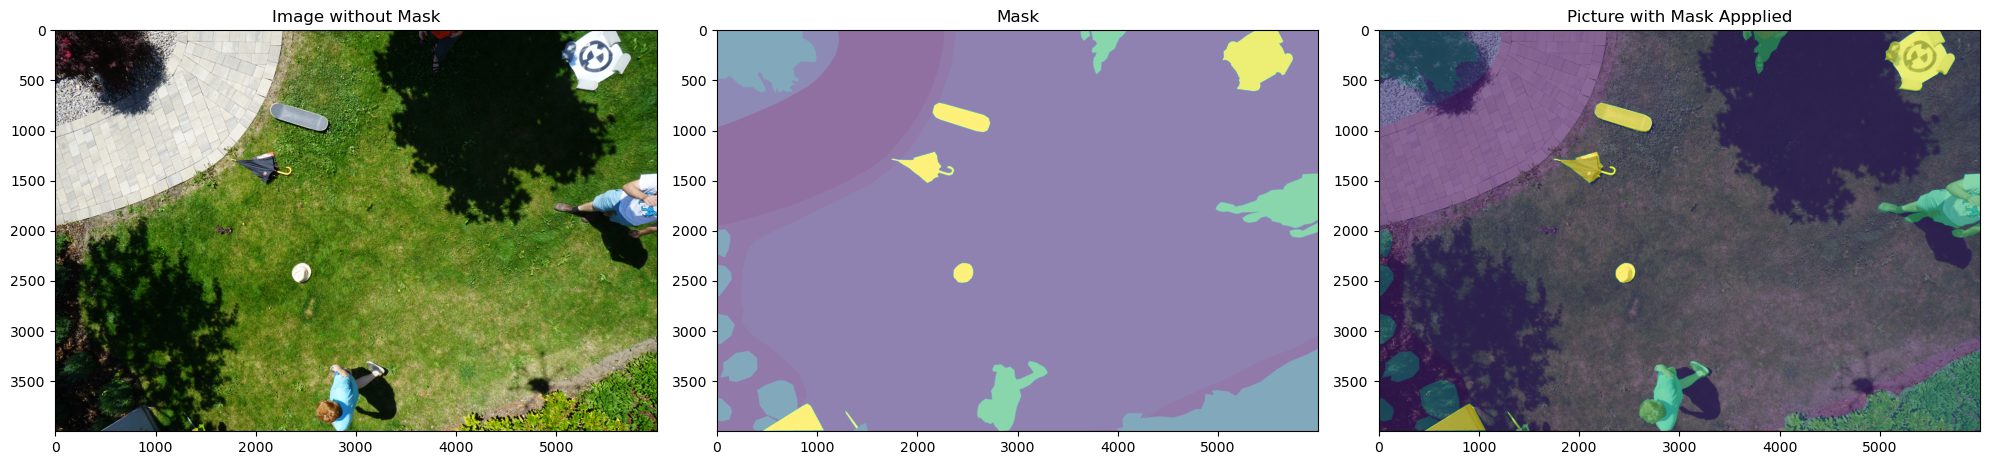

In [18]:
# Random sample visualization
idx_sample = np.random.randint(0, len(df)-1)
img = Image.open(IMG_PATH + df['id'][idx_sample] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][idx_sample] + '.png')

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

ax[0].imshow(img)
ax[0].set_title('Image without Mask')

ax[1].imshow(mask, alpha=0.6)
ax[1].set_title('Mask')

ax[2].imshow(img)
ax[2].imshow(mask, alpha=0.6)
ax[2].set_title('Picture with Mask Appplied')


# Adjust the layout to avoid overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

## Preparing the dataset

In [26]:
class AerialImagesDataset(Dataset):
   
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        # Initializes the dataset
        # Args:
        #   img_path (str): Path to the directory containing the image files
        #   mask_path (str): Path to the directory containing the mask files
        #   X (list): List of image file names (without extensions)
        #   mean (tuple): Mean values for image normalization
        #   std (tuple): Standard deviation values for image normalization
        #   transform (optional): Image transformation function
        #   patch (bool): Flag indicating whether to use patch extractions
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch
        
    def __len__(self):
        # Returns the length of the dataset
        return len(self.X)
    
    def __getitem__(self, idx):
        # Retrieves an item from the dataset
        # Args:
        # idx (int): Index of the item to retrieve
        
        # Read the image file
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        # Convert the image to RGB color space
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Read the mask file in grayscale
        mask = cv2.imread(self.mask_path +self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            # Apply image transformation if provided
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        else:
            img = Image.fromarray(img)
            
        # Convert the image to a tensor and normalize it
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        # Convert the mask to a tensor
        mask = torch.from_numpy(mask).long()
        
        if self.patch:
            # Extract patches from the image and mask
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):
        # Extracts patches from the image and mask
        # Useful in scenarios such as training deep learning models 
        # on limited computational resources or handling large images efficiently.
        # Args:
        #   img (tensor): Input image tensor
        #   mask (tensor): Input mask tensor
        img_patch = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patch = img_patch.contiguous().view(3, -1, 512, 768)
        img_patch = img_patch.permute(1, 0, 2, 3)
        
        mask_patch = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patch = mask_patch.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [29]:
mean=[0.485, 0.456, 0.406]  # For normalization
std=[0.229, 0.224, 0.225]  # For normalization

# Data augmentation
t_train = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),  # Resize the image and mask to specified dimensions
    A.HorizontalFlip(),  # Apply horizontal flip augmentation
    A.VerticalFlip(),  # Apply vertical flip augmentation
    A.GridDistortion(p=0.2),  # Apply grid distortion augmentation with a probability of 0.2
    A.RandomBrightnessContrast((0,0.5), (0,0.5)),  # Apply random brightness and contrast augmentation within specified ranges
    A.GaussNoise()  # Apply Gaussian noise augmentation
])

t_val = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),  # Resize the image and mask to specified dimensions
    A.HorizontalFlip(),  # Apply horizontal flip augmentation
    A.GridDistortion(p=0.2)  # Apply grid distortion augmentation with a probability of 0.2
])

# Datasets creation (include normalization -> mean, std and data augmentation -> t_train, t_val)
train_set = AerialImagesDataset(
    IMG_PATH,  # Path to the images
    MASK_PATH,  # Path to the masks
    X_train,  # List of training data filenames
    mean,  # Mean values for normalization
    std,  # Standard deviation values for normalization
    t_train,  # Transformations to apply to training data
    patch=False  # Whether to extract patches from images (set to False in this case)
)

val_set = AerialImagesDataset(
    IMG_PATH,  # Path to the images
    MASK_PATH,  # Path to the masks
    X_val,  # List of validation data filenames
    mean,  # Mean values for normalization
    std,  # Standard deviation values for normalization
    t_val,  # Transformations to apply to validation data
    patch=False  # Whether to extract patches from images (set to False in this case)
)

# Data loaders
batch_size = 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)  # Create a data loader for training set
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)  # Create a data loader for validation set
 

## Model

In [19]:
# Create a UNet model using the 'mobilenet_v2' encoder
# Set the encoder weights to pre-trained 'imagenet' weights
# The model is designed to classify into 23 classes
# The activation function is set to None, no specific activation function is used.
# The model has an encoder depth of 5, which refers to the number of encoder blocks in the UNet architecture.
# The decoder channels are set as [256, 128, 64, 32, 16], These channels determine the number of output feature maps at each decoder block.
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 50.5MB/s]


In [20]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

## Training

In [21]:
def pixel_accuracy(output, mask):
    with torch.no_grad():  # Disable gradient calculation since we only need to calculate accuracy
        output = torch.argmax(F.softmax(output, dim=1), dim=1)  # Get the predicted class labels by finding the indices of the maximum probabilities along dimension 1
        correct = torch.eq(output, mask).int()  # Compare the predicted labels with the ground truth mask and convert the resulting boolean tensor to an integer tensor
        accuracy = float(correct.sum()) / float(correct.numel())  # Calculate the accuracy by dividing the sum of correct predictions by the total number of predictions
    return accuracy

In [22]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad(): # Disable gradient calculation
        pred_mask = F.softmax(pred_mask, dim=1) # Apply softmax activation to predicted mask
        pred_mask = torch.argmax(pred_mask, dim=1) # Get the class with the highest probability for each pixel
        pred_mask = pred_mask.contiguous().view(-1) # Reshape predicted mask to a 1-dimensional tensor
        mask = mask.contiguous().view(-1) # Reshape true mask to a 1-dimensional tensor

        iou_per_class = [] # Initialize a list to store IoU values per class
        for clas in range(0, n_classes): # Loop through each pixel class
            true_class = pred_mask == clas # Check if predicted class matches the current class
            true_label = mask == clas # Check if true class matches the current class

            if true_label.long().sum().item() == 0: # If no pixels of the current class exist in the true mask
                iou_per_class.append(np.nan) # Append NaN (Not a Number) to the IoU list
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item() # Calculate the number of pixels where both predicted and true masks are true
                union = torch.logical_or(true_class, true_label).sum().float().item() # Calculate the number of pixels where either predicted or true mask is true

                iou = (intersect + smooth) / (union + smooth) # Calculate the IoU for the current class
                iou_per_class.append(iou) # Append the IoU to the IoU list
        return np.nanmean(iou_per_class) # Calculate the mean IoU across all classes, ignoring NaN values

In [30]:
def get_lr(optimizer):
    # Function to get the learning rate from the optimizer
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    # Function to train the model for the specified number of epochs
    torch.cuda.empty_cache()
    train_losses = []  # List to store training losses
    test_losses = []   # List to store validation losses
    val_iou = []       # List to store validation mIoU scores
    val_acc = []       # List to store validation accuracy scores
    train_iou = []     # List to store training mIoU scores
    train_acc = []     # List to store training accuracy scores
    lrs = []           # List to store learning rates
    min_loss = np.inf  # Initialize the minimum validation loss with infinity
    decrease = 1       # Counter for tracking consecutive decrease in validation loss
    not_improve = 0    # Counter for tracking consecutive non-decrease in validation loss

    model.to(device)   # Move the model to the specified device
    fit_time = time.time()  # Record the starting time of training
    for e in range(epochs):
        since = time.time()  # Record the starting time of current epoch
        running_loss = 0    # Initialize the training loss for the epoch
        iou_score = 0       # Initialize the training mIoU score for the epoch
        accuracy = 0        # Initialize the training accuracy score for the epoch
        
        # Training loop
        model.train()  # Set the model to train mode
        for i, data in enumerate(tqdm(train_loader)):
            # Training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
            
            # Forward pass
            output = model(image)
            loss = criterion(output, mask)
            
            # Evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()  # Update weights          
            optimizer.zero_grad()  # Reset gradients
            
            # Step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        # Validation phase   
        else:
            model.eval()  # Set the model to evaluation mode
            test_loss = 0  # Initialize the validation loss
            test_accuracy = 0  # Initialize the validation accuracy
            val_iou_score = 0  # Initialize the validation mIoU score
            
            # Validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    # Reshape to 9 patches from a single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    output = model(image)
                    
                    # Evaluation metrics
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    
                    # Loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            # Calculate mean for each batch
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            if min_loss > (test_loss / len(val_loader)):
                # If current validation loss is smaller than the minimum loss, save the model
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss / len(val_loader))))
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score / len(val_loader)))

            if (test_loss / len(val_loader)) > min_loss:
                # If validation loss is not decreasing, update the counter
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            # Metrics
            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
                  "Time: {:.2f}m".format((time.time() - since) / 60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' : train_iou, 'val_miou': val_iou,
               'train_acc' : train_acc, 'val_acc': val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time() - fit_time) / 60))
    return history

In [31]:
# Set the maximum learning rate
max_lr = 1e-3

# Set the number of epochs
epoch = 15

# Set the weight decay value
weight_decay = 1e-4

# Define the criterion for calculating the loss
criterion = nn.CrossEntropyLoss()

# Define the optimizer with AdamW and the given learning rate and weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)

# Define the learning rate scheduler with OneCycleLR, using the optimizer, maximum learning rate, number of epochs, and steps per epoch
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

# Fit the model to the data for the given number of epochs using the defined criterion, optimizer, and scheduler
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.070 
Epoch:1/15.. Train Loss: 2.772.. Val Loss: 2.070.. Train mIoU:0.049.. Val mIoU: 0.081.. Train Acc:0.258.. Val Acc:0.500.. Time: 4.34m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.070 >> 1.347 
Epoch:2/15.. Train Loss: 1.818.. Val Loss: 1.347.. Train mIoU:0.092.. Val mIoU: 0.096.. Train Acc:0.544.. Val Acc:0.627.. Time: 4.03m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 1.420.. Val Loss: 1.356.. Train mIoU:0.130.. Val mIoU: 0.125.. Train Acc:0.610.. Val Acc:0.617.. Time: 4.00m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.356 >> 1.123 
Epoch:4/15.. Train Loss: 1.358.. Val Loss: 1.123.. Train mIoU:0.143.. Val mIoU: 0.160.. Train Acc:0.610.. Val Acc:0.704.. Time: 4.02m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:5/15.. Train Loss: 1.268.. Val Loss: 1.143.. Train mIoU:0.160.. Val mIoU: 0.154.. Train Acc:0.632.. Val Acc:0.668.. Time: 4.02m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.143 >> 1.080 
saving model...
Epoch:6/15.. Train Loss: 1.140.. Val Loss: 1.080.. Train mIoU:0.176.. Val mIoU: 0.172.. Train Acc:0.670.. Val Acc:0.659.. Time: 3.98m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.080 >> 1.031 
Epoch:7/15.. Train Loss: 1.093.. Val Loss: 1.031.. Train mIoU:0.190.. Val mIoU: 0.198.. Train Acc:0.679.. Val Acc:0.717.. Time: 4.01m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.031 >> 0.820 
Epoch:8/15.. Train Loss: 0.996.. Val Loss: 0.820.. Train mIoU:0.204.. Val mIoU: 0.213.. Train Acc:0.704.. Val Acc:0.758.. Time: 4.06m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.820 >> 0.735 
Epoch:9/15.. Train Loss: 0.932.. Val Loss: 0.735.. Train mIoU:0.218.. Val mIoU: 0.251.. Train Acc:0.724.. Val Acc:0.785.. Time: 4.04m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.735 >> 0.729 
Epoch:10/15.. Train Loss: 0.869.. Val Loss: 0.729.. Train mIoU:0.233.. Val mIoU: 0.250.. Train Acc:0.739.. Val Acc:0.784.. Time: 4.05m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.729 >> 0.696 
saving model...
Epoch:11/15.. Train Loss: 0.809.. Val Loss: 0.696.. Train mIoU:0.249.. Val mIoU: 0.259.. Train Acc:0.758.. Val Acc:0.789.. Time: 4.07m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.696 >> 0.671 
Epoch:12/15.. Train Loss: 0.759.. Val Loss: 0.671.. Train mIoU:0.266.. Val mIoU: 0.282.. Train Acc:0.775.. Val Acc:0.800.. Time: 4.03m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.671 >> 0.628 
Epoch:13/15.. Train Loss: 0.700.. Val Loss: 0.628.. Train mIoU:0.282.. Val mIoU: 0.273.. Train Acc:0.792.. Val Acc:0.808.. Time: 4.01m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.628 >> 0.624 
Epoch:14/15.. Train Loss: 0.677.. Val Loss: 0.624.. Train mIoU:0.289.. Val mIoU: 0.282.. Train Acc:0.798.. Val Acc:0.810.. Time: 4.03m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:15/15.. Train Loss: 0.662.. Val Loss: 0.630.. Train mIoU:0.290.. Val mIoU: 0.286.. Train Acc:0.801.. Val Acc:0.807.. Time: 4.02m
Total time: 60.71 m


In [32]:
torch.save(model, 'Unet-Mobilenet.pt')

In [33]:
# This function plots the validation and training loss per epoch.
# It takes a dictionary 'history' as input, which contains the loss values.
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')  # Plotting validation loss
    plt.plot(history['train_loss'], label='train', marker='o')  # Plotting training loss
    plt.title('Loss per epoch')  # Setting the title of the plot
    plt.ylabel('loss')  # Setting the y-axis label
    plt.xlabel('epoch')  # Setting the x-axis label
    plt.legend()  # Displaying the legend
    plt.grid()  # Displaying grid lines
    plt.show()  # Showing the plot

# This function plots the training and validation mean IoU (Intersection over Union) score per epoch.
# It takes a dictionary 'history' as input, which contains the score values.
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')  # Plotting training mean IoU
    plt.plot(history['val_miou'], label='val_mIoU', marker='*')  # Plotting validation mean IoU
    plt.title('Score per epoch')  # Setting the title of the plot
    plt.ylabel('mean IoU')  # Setting the y-axis label
    plt.xlabel('epoch')  
    plt.legend()  
    plt.grid()  
    plt.show()  

# This function plots the training and validation accuracy per epoch.
# It takes a dictionary 'history' as input, which contains the accuracy values.
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')  # Plotting training accuracy
    plt.plot(history['val_acc'], label='val_accuracy', marker='*')  # Plotting validation accuracy
    plt.title('Accuracy per epoch')  # Setting the title of the plot
    plt.ylabel('Accuracy')  # Setting the y-axis label
    plt.xlabel('epoch') 
    plt.legend()  
    plt.grid()  
    plt.show()  


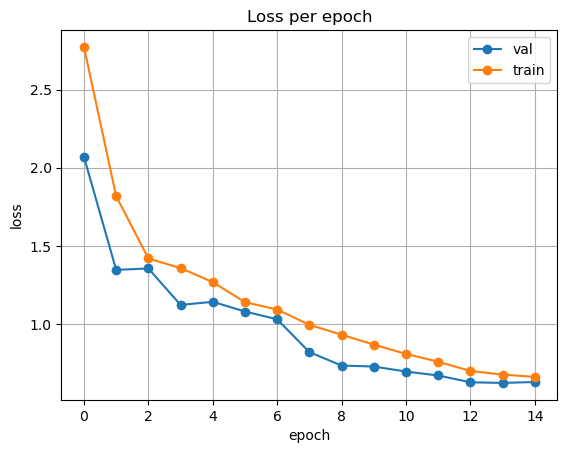

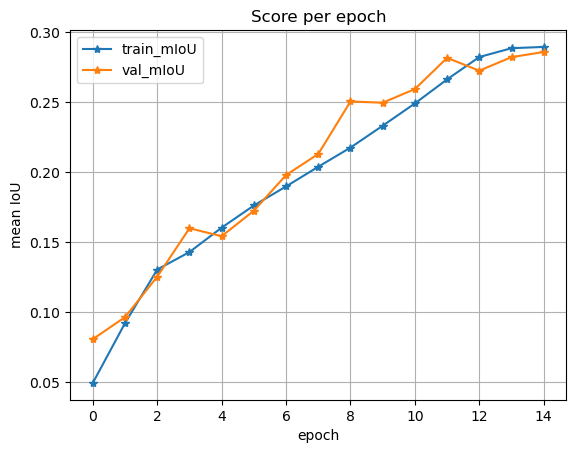

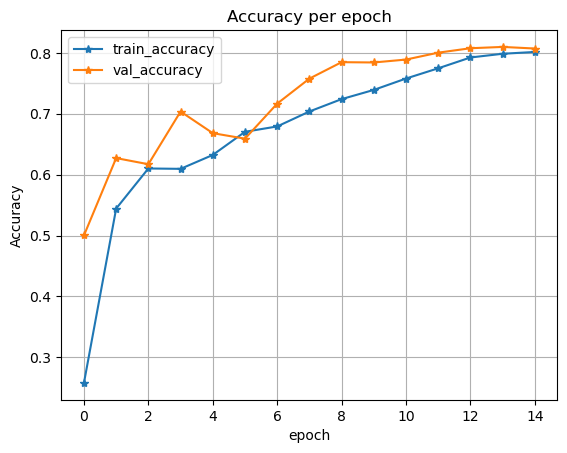

In [34]:
plot_loss(history)
plot_score(history)
plot_acc(history)

## Evaluation and results

In [35]:
# Define a class called DroneTestDataset
class AerialImagesTestDataset(Dataset):
    
    # Initialize the class and set the initial values
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path  # Path to the images
        self.mask_path = mask_path  # Path to the masks
        self.X = X  # List of image names
        self.transform = transform  # Image transformation
      
    # Get the length of the dataset
    def __len__(self):
        return len(self.X)
    
    # Get an item from the dataset based on its index
    def __getitem__(self, idx):
        # Read the image using OpenCV
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        # Convert the image from BGR to RGB color space
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Read the mask image using OpenCV in grayscale mode
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        # Apply transformation if available
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            # Convert the augmented image to PIL Image
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        # If no transformation, convert the image to PIL Image
        if self.transform is None:
            img = Image.fromarray(img)
        
        # Convert the mask to a Torch tensor with 'long' data type
        mask = torch.from_numpy(mask).long()
        
        # Return the image and mask
        return img, mask


# Define a transformation to resize the images
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

# Create an instance of the DroneTestDataset class with the specified parameters
test_set = AerialImagesTestDataset(IMG_PATH, MASK_PATH, X_test, transform=t_test)

In [36]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])  # Define a transformation pipeline
    image = t(image)  # Apply the transformation to the image
    model.to(device)  # Move the model to the specified device
    image = image.to(device)  # Move the image to the specified device
    mask = mask.to(device)  # Move the mask to the specified device
    with torch.no_grad():  # Disable gradient computation
        
        image = image.unsqueeze(0)  # Add a batch dimension to the image
        mask = mask.unsqueeze(0)  # Add a batch dimension to the mask
        
        output = model(image)  # Forward pass through the model to obtain the output
        score = mIoU(output, mask)  # Compute the mean Intersection over Union (mIoU) score
        masked = torch.argmax(output, dim=1)  # Obtain the predicted mask by taking the argmax along the channel dimension
        masked = masked.cpu().squeeze(0)  # Move the predicted mask to the CPU and remove the batch dimension
    return masked, score  # Return the predicted mask and the mIoU score


In [37]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode

    # Define a transformation pipeline for preprocessing the image
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])

    image = t(image)  # Apply the transformation to the image
    model.to(device)  # Move the model to the specified device (e.g., GPU)
    image = image.to(device)  # Move the image tensor to the specified device
    mask = mask.to(device)  # Move the mask tensor to the specified device

    with torch.no_grad():  # Disable gradient calculation to save memory and computation

        # Add a batch dimension to the image and mask tensors
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        # Forward pass through the model to get the output predictions
        output = model(image)

        # Calculate the pixel accuracy between the predicted output and the mask
        acc = pixel_accuracy(output, mask)

        # Apply argmax to get the predicted class indices
        masked = torch.argmax(output, dim=1)

        # Move the tensor to CPU and squeeze the batch dimension
        masked = masked.cpu().squeeze(0)

    return masked, acc


In [38]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [39]:
def miou_score(model, test_set):
    # This function calculates the mean intersection over union (IoU) score for a given model and test dataset.
    # The IoU score measures the overlap between the predicted mask and the ground truth mask.

    score_iou = []  # List to store individual IoU scores for each image in the test set.

    # Iterate over each image in the test set.
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]  # Retrieve the image and ground truth mask.
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        # Predict the mask for the image using the model and calculate the IoU score.

        score_iou.append(score)  # Add the calculated IoU score to the list.

    return score_iou  # Return the list of IoU scores.

In [40]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [41]:
def pixel_acc(model, test_set):
    # This function calculates the pixel accuracy of a model on a test set.
    
    accuracy = []  # List to store the accuracy for each image
    
    # Loop through each image in the test set
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]  # Get the image and corresponding mask
        
        # Predict the mask using the model and calculate accuracy
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        
        accuracy.append(acc)  # Append the accuracy to the list
        
    return accuracy  # Return the list of accuracies

In [42]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

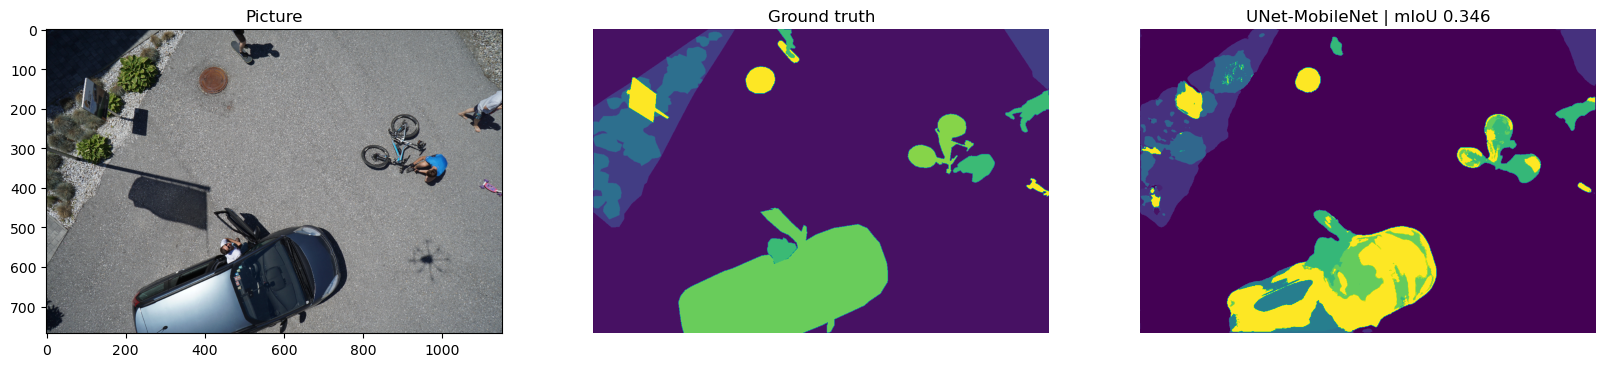

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

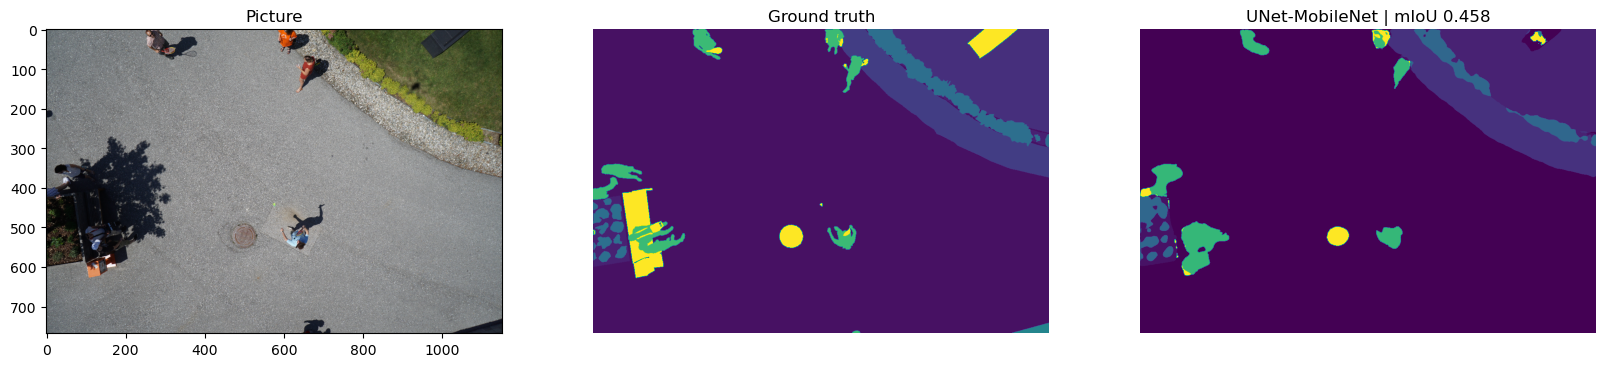

In [44]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

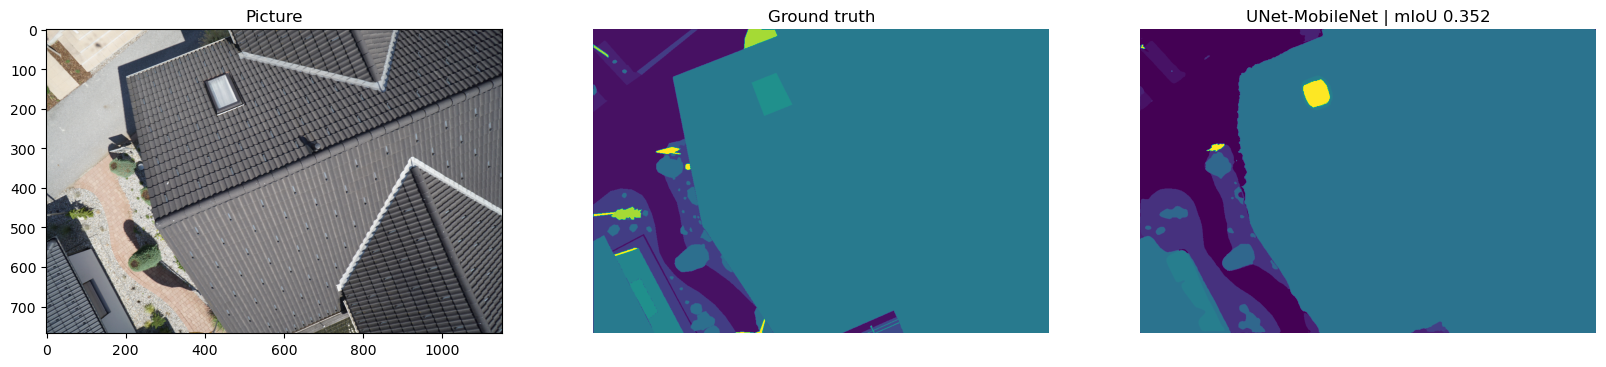

In [45]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [46]:
print('Test Set mIoU', np.mean(mob_miou))
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set mIoU 0.33174968317400816
Test Set Pixel Accuracy 0.8207625212492765
